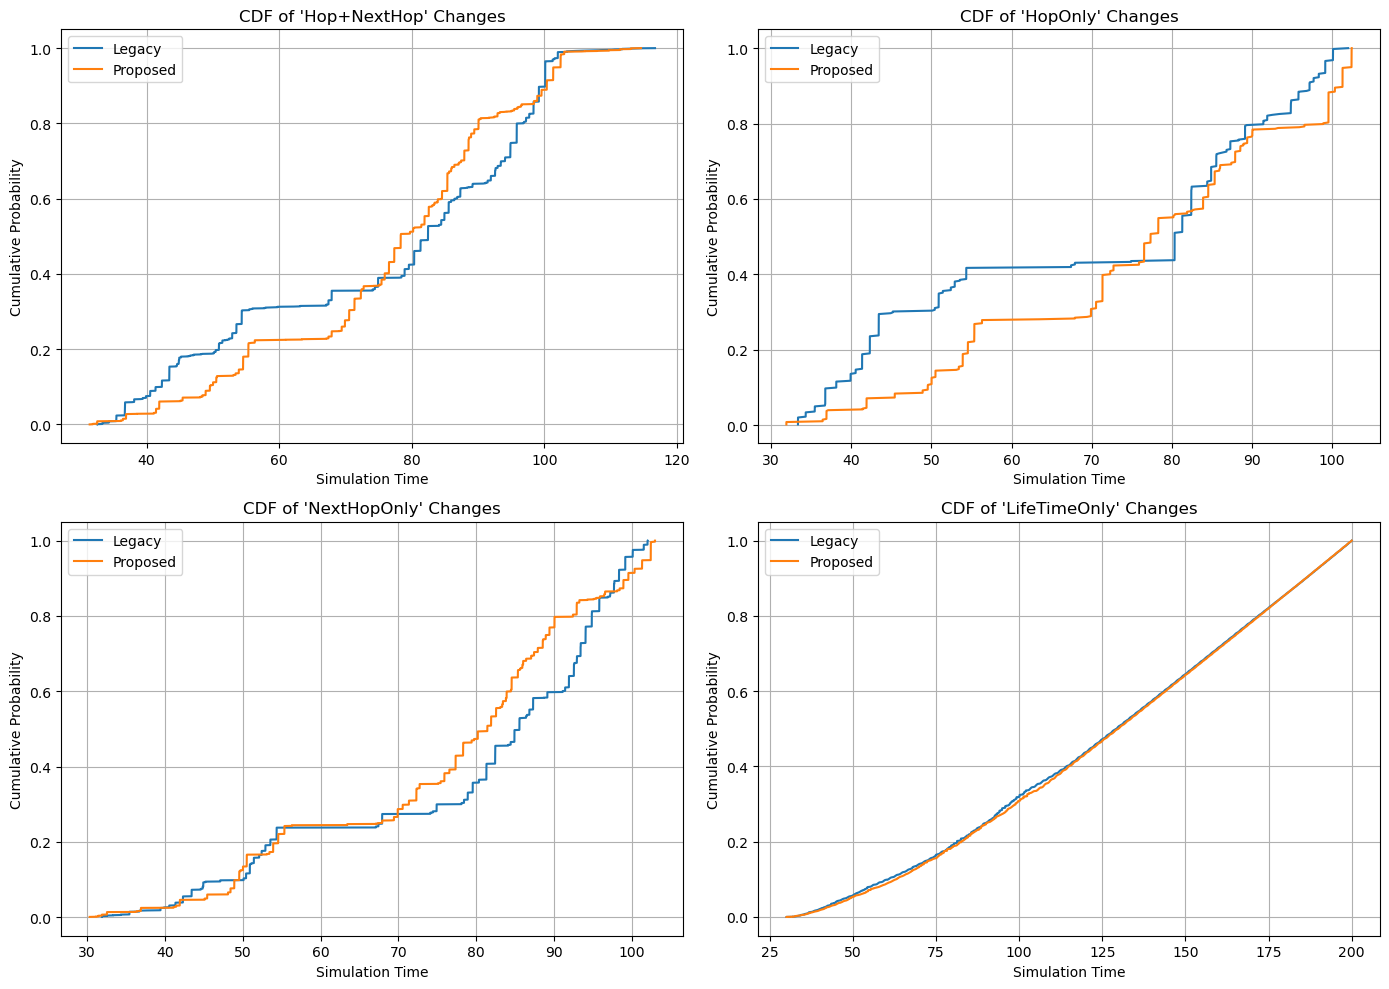

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 로딩 함수
def load_routing_log(path):
    df = pd.read_csv(path)
    df.columns = ["Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime", "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"]
    return df

# 변화 유형 분류
def classify_change_type(df):
    def get_change_type(row):
        hop_changed = row["Previous_HopCount"] != row["New_HopCount"]
        nhop_changed = row["Previous_NextHop"] != row["New_NextHop"]
        if hop_changed and nhop_changed:
            return "Hop+NextHop"
        elif hop_changed:
            return "HopOnly"
        elif nhop_changed:
            return "NextHopOnly"
        else:
            return "LifeTimeOnly"
    df["ChangeType"] = df.apply(get_change_type, axis=1)
    return df

# CDF 그리기
def plot_cdf(df_legacy, df_proposed):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly", "LifeTimeOnly"]
    colors = ['blue', 'orange', 'red', 'green']
    axs = axs.flatten()

    for i, ctype in enumerate(change_types):
        for label, df in [("Legacy", df_legacy), ("Proposed", df_proposed)]:
            times = df[df["ChangeType"] == ctype]["Time"].sort_values()
            y = np.arange(1, len(times)+1) / len(times)
            axs[i].plot(times, y, label=label)

        axs[i].set_title(f"CDF of '{ctype}' Changes")
        axs[i].set_xlabel("Simulation Time")
        axs[i].set_ylabel("Cumulative Probability")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

# 실행
legacy_df = classify_change_type(load_routing_log("Legacy/aodv_routing_log.csv"))
proposed_df = classify_change_type(load_routing_log("Proposed/aodv_routing_log.csv"))
plot_cdf(legacy_df, proposed_df)


In [ ]:
import pandas as pd # type: ignore

def load_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    return df

def classify_change_types(df):
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def summarize_change_types(df):
    return df["ChangeType"].value_counts().sort_index()

def compare_change_type_stats(path_legacy, path_proposed):
    df_legacy = classify_change_types(load_routing_log(path_legacy))
    df_proposed = classify_change_types(load_routing_log(path_proposed))

    summary_legacy = summarize_change_types(df_legacy)
    summary_proposed = summarize_change_types(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy": summary_legacy,
        "Proposed": summary_proposed
    }).fillna(0).astype(int)

    return df_compare

result = compare_change_type_stats("Legacy/aodv_routing_log.csv", "Proposed/aodv_routing_log.csv")
print(result)


              Legacy  Proposed
ChangeType                    
Hop+NextHop     3571      4213
HopOnly          441       477
LifeTimeOnly  777453    782716
NextHopOnly     1987      2340


              Legacy  Proposed
ChangeType                    
LifeTimeOnly  777453    782716
Hop+NextHop     3571      4213
NextHopOnly     1987      2340
HopOnly          441       477


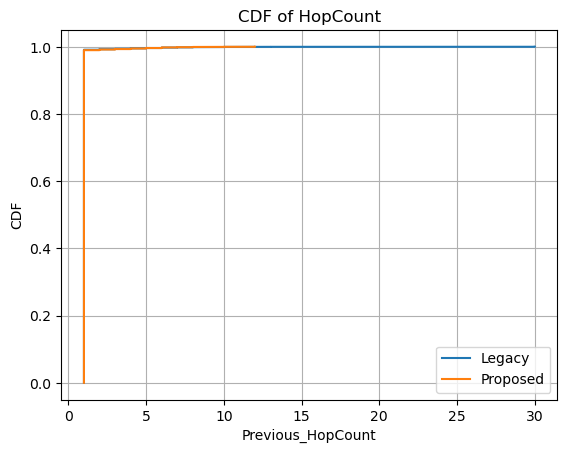

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_change_type(df):
    df["HopChanged"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChanged"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["ChangeType"] = (
        df["HopChanged"].astype(int).astype(str) + df["NextHopChanged"].astype(int).astype(str)
    )
    mapping = {
        "00": "LifeTimeOnly",
        "10": "HopOnly",
        "01": "NextHopOnly",
        "11": "Hop+NextHop"
    }
    df["ChangeType"] = df["ChangeType"].map(mapping)
    return df

def count_change_types(df_legacy, df_proposed):
    legacy = compute_change_type(df_legacy)["ChangeType"].value_counts().rename("Legacy")
    proposed = compute_change_type(df_proposed)["ChangeType"].value_counts().rename("Proposed")
    result = pd.concat([legacy, proposed], axis=1).fillna(0).astype(int)
    return result

def plot_cdf(data_legacy, data_proposed, column, title):
    legacy_sorted = data_legacy[column].sort_values()
    proposed_sorted = data_proposed[column].sort_values()
    legacy_cdf = legacy_sorted.rank(method='first') / len(legacy_sorted)
    proposed_cdf = proposed_sorted.rank(method='first') / len(proposed_sorted)

    plt.figure()
    plt.plot(legacy_sorted, legacy_cdf, label="Legacy", drawstyle="steps-post")
    plt.plot(proposed_sorted, proposed_cdf, label="Proposed", drawstyle="steps-post")
    plt.xlabel(column)
    plt.ylabel("CDF")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
# 호출 예시

# Legacy 및 Proposed 로그 파일 로드
legacy_log = pd.read_csv("Legacy/aodv_routing_log.csv")
proposed_log = pd.read_csv("Proposed/aodv_routing_log.csv")

# 변화 유형 집계
change_types = count_change_types(legacy_log, proposed_log)
print(change_types)

# CDF 분석 예시 (HopCount 또는 LifeTime 등 컬럼으로 분석)
plot_cdf(legacy_log, proposed_log, "Previous_HopCount", "CDF of HopCount")



In [ ]:
import pandas as pd

legacy_df = pd.read_csv("Legacy/aodv_routing_log.csv")
proposed_df = pd.read_csv("Proposed/aodv_routing_log.csv")

legacy_rreq_count = legacy_df[legacy_df["Event"] == "RREQ_SENT"].shape[0]
proposed_rreq_count = proposed_df[proposed_df["Event"] == "RREQ_SENT"].shape[0]

legacy_merged = legacy_df[legacy_df["Event"] == "RREP_RECV"]  # 성공 건수 필터링
proposed_merged = proposed_df[proposed_df["Event"] == "RREP_RECV"]  # 성공 건수 필터링

legacy_success_count = legacy_merged.shape[0]
proposed_success_count = proposed_merged.shape[0]

legacy_success_rate = legacy_success_count / legacy_rreq_count if legacy_rreq_count else 0
proposed_success_rate = proposed_success_count / proposed_rreq_count if proposed_rreq_count else 0

result_df = pd.DataFrame({
    "Total RREQ Sent": [legacy_rreq_count, proposed_rreq_count],
    "Successful Recovery": [legacy_success_count, proposed_success_count],
    "Success Rate": [legacy_success_rate, proposed_success_rate]
}, index=["Legacy", "Proposed"])

print(result_df)


KeyError: 'Event'

In [ ]:
import pandas as pd

legacy_df = pd.read_csv("Legacy/aodv_routing_log.csv")
proposed_df = pd.read_csv("Proposed/aodv_routing_log.csv")

print("Legacy DataFrame Columns:", legacy_df.columns)
print("Proposed DataFrame Columns:", proposed_df.columns)

legacy_rreq_count = legacy_df[legacy_df['Previous_HopCount'] != legacy_df['New_HopCount']].shape[0]
proposed_rreq_count = proposed_df[proposed_df['Previous_HopCount'] != proposed_df['New_HopCount']].shape[0]

legacy_success_count = legacy_df[legacy_df['New_LifeTime'] > legacy_df['Previous_LifeTime']].shape[0]
proposed_success_count = proposed_df[proposed_df['New_LifeTime'] > proposed_df['Previous_LifeTime']].shape[0]

legacy_success_rate = legacy_success_count / legacy_rreq_count if legacy_rreq_count else 0
proposed_success_rate = proposed_success_count / proposed_rreq_count if proposed_rreq_count else 0

print("Legacy Success Rate:", legacy_success_rate)
print("Proposed Success Rate:", proposed_success_rate)

success_rate_df = pd.DataFrame({
    "Total RREQ Sent": [legacy_rreq_count, proposed_rreq_count],
    "Successful Recovery": [legacy_success_count, proposed_success_count],
    "Success Rate": [legacy_success_rate, proposed_success_rate]
}, index=["Legacy", "Proposed"])

print(success_rate_df)


Legacy DataFrame Columns: Index(['Time', 'Node', 'Destination', 'Previous_LifeTime', 'New_LifeTime',
       'Previous_NextHop', 'New_NextHop', 'Previous_HopCount', 'New_HopCount'],
      dtype='object')
Proposed DataFrame Columns: Index(['Time', 'Node', 'Destination', 'Previous_LifeTime', 'New_LifeTime',
       'Previous_NextHop', 'New_NextHop', 'Previous_HopCount', 'New_HopCount'],
      dtype='object')
Legacy Success Rate: 193.18693918245265
Proposed Success Rate: 166.71748400852877
          Total RREQ Sent  Successful Recovery  Success Rate
Legacy               4012               775066    193.186939
Proposed             4690               781905    166.717484


In [ ]:
print("Legacy DataFrame Columns:", legacy_df.columns)
print("Proposed DataFrame Columns:", proposed_df.columns)


Legacy DataFrame Columns: Index(['Time', 'Node', 'Destination', 'Previous_LifeTime', 'New_LifeTime',
       'Previous_NextHop', 'New_NextHop', 'Previous_HopCount', 'New_HopCount'],
      dtype='object')
Proposed DataFrame Columns: Index(['Time', 'Node', 'Destination', 'Previous_LifeTime', 'New_LifeTime',
       'Previous_NextHop', 'New_NextHop', 'Previous_HopCount', 'New_HopCount'],
      dtype='object')


In [ ]:
legacy_rreq_count = legacy_df[legacy_df["Node"].notnull() & legacy_df["Destination"].notnull()].shape[0]
proposed_rreq_count = proposed_df[proposed_df["Node"].notnull() & proposed_df["Destination"].notnull()].shape[0]

legacy_success_count = legacy_df[legacy_df["New_LifeTime"] != legacy_df["Previous_LifeTime"]].shape[0]
proposed_success_count = proposed_df[proposed_df["New_LifeTime"] != proposed_df["Previous_LifeTime"]].shape[0]

legacy_success_rate = legacy_success_count / legacy_rreq_count if legacy_rreq_count else 0
proposed_success_rate = proposed_success_count / proposed_rreq_count if proposed_rreq_count else 0

result = pd.DataFrame({
    "Total RREQ Sent": [legacy_rreq_count, proposed_rreq_count],
    "Successful Recovery": [legacy_success_count, proposed_success_count],
    "Success Rate": [legacy_success_rate, proposed_success_rate]
}, index=["Legacy", "Proposed"])

print(result)


          Total RREQ Sent  Successful Recovery  Success Rate
Legacy             783452               783341      0.999858
Proposed           789746               789661      0.999892


In [ ]:
import pandas as pd

def calculate_recovery_delay(log_path):
    df = pd.read_csv(log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    
    delays = []
    grouped = df.groupby(["Node", "Destination"])

    for (node, dest), group in grouped:
        group = group.sort_values("Time")
        rerr_times = group[group["Event"] == "RERR_SENT"]["Time"].tolist()
        rrep_times = group[group["Event"] == "RREP_RECV"]["Time"].tolist()

        i = j = 0
        while i < len(rerr_times) and j < len(rrep_times):
            if rrep_times[j] > rerr_times[i]:
                delays.append(rrep_times[j] - rerr_times[i])
                i += 1
                j += 1
            else:
                j += 1

    return delays

legacy_delays = calculate_recovery_delay("Legacy/recovery_log.csv")
proposed_delays = calculate_recovery_delay("Proposed/recovery_log.csv")

print(f"Legacy 평균 복구 지연: {sum(legacy_delays)/len(legacy_delays):.6f}초")
print(f"Proposed 평균 복구 지연: {sum(proposed_delays)/len(proposed_delays):.6f}초")


Legacy 평균 복구 지연: 1.678654초
Proposed 평균 복구 지연: 3.189669초


In [ ]:
import pandas as pd

def calculate_proactive_lifetime_extension_rate(log_path):
    df = pd.read_csv(log_path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]

    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )

    lt_only_df = df[df["ChangeType"] == "LifeTimeOnly"].copy()
    lt_only_df["TimeToExpire"] = lt_only_df["Previous_LifeTime"] - lt_only_df["Time"]

    proactive = lt_only_df[lt_only_df["TimeToExpire"] <= 3.0]

    rate = len(proactive) / len(lt_only_df) * 100 if len(lt_only_df) > 0 else 0
    return rate

legacy_rate = calculate_proactive_lifetime_extension_rate("Legacy/aodv_routing_log.csv")
proposed_rate = calculate_proactive_lifetime_extension_rate("Proposed/aodv_routing_log.csv")

print(f"Legacy 선제 갱신률: {legacy_rate:.2f}%")
print(f"Proposed 선제 갱신률: {proposed_rate:.2f}%")


Legacy 선제 갱신률: 99.03%
Proposed 선제 갱신률: 97.02%


In [ ]:
import pandas as pd

def estimate_success_rate_after_change_from_recovery_log(
    routing_log_path, recovery_log_path, change_type="Hop+NextHop", interval=1.0
):
    df = pd.read_csv(routing_log_path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    changed_df = df[df["ChangeType"] == change_type][["Time", "Node", "Destination"]]

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"]

    success = 0
    total = 0

    for _, row in changed_df.iterrows():
        t_start = row["Time"]
        t_end = t_start + interval
        dest = str(row["Destination"])

        matched = rrep_df[
            (rrep_df["Destination"].astype(str) == dest) &
            (rrep_df["Time"] >= t_start) & (rrep_df["Time"] <= t_end)
        ]

        total += 1
        if not matched.empty:
            success += 1

    rate = (success / total) * 100 if total > 0 else 0
    return rate

legacy_rate = estimate_success_rate_after_change_from_recovery_log(
    "Legacy/aodv_routing_log.csv", "Legacy/recovery_log.csv"
)
proposed_rate = estimate_success_rate_after_change_from_recovery_log(
    "Proposed/aodv_routing_log.csv", "Proposed/recovery_log.csv"
)

print(f"Legacy Hop+NextHop 변화 후 RREP 수신률: {legacy_rate:.2f}%")
print(f"Proposed Hop+NextHop 변화 후 RREP 수신률: {proposed_rate:.2f}%")


Legacy Hop+NextHop 변화 후 RREP 수신률: 19.77%
Proposed Hop+NextHop 변화 후 RREP 수신률: 30.41%
